In [ ]:
# !pip install --upgrade pip

In [ ]:
# !pip install -q arviz causalgraphicalmodels daft
# !pip install --upgrade jax[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade numpyro[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
# !python -m pip freeze --local > ../requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os


import arviz as az
import matplotlib.pyplot as plt

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import numpy as np


from numpyro.diagnostics import print_summary
from numpyro.distributions.transforms import OrderedTransform
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Predictive
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import pandas as pd
import seaborn as sns

from scipy.stats import norm

from torch import tensor

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')
numpyro.util.enable_x64(False)


random_seed = 9939
random_key = random.PRNGKey(random_seed)

Inv_Cumulative_Normal = norm.ppf

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

In [3]:
run_basename = 'sim/test_new_steez_prevalence_.02_h2_.5_rho_.8_pi.1_piboth_05'

In [4]:
!cat {run_basename}.json | jq

{
  "total_N": 200000,
  "disease_gene_counts": [
    1981,
    1988,
    1017
  ],
  "expected_mutations_per_person": 4,
  "h2": [
    0.5,
    0.5
  ],
  "observed_prevalences": [
    0.03634,
    0.03661,
    0.00489
  ],
  "genetic_variance_liability": [
    0.503360576725371,
    0.511060247135165
  ],
  "residual_variance_liability": [
    0.499760533968276,
    0.502082360765383
  ],
  "total_variance_before_normalization": [
    0.500822836023907,
    0.510613104971409
  ],
  "expected_risk_mutations_per_person": 1,
  "prevalence_expected": [
    0.02,
    0.02
  ],
  "rho": 0.8,
  "prevalence_actual": [
    0.03634,
    0.03661
  ],
  "sigma": [
    0.912916576145287,
    0.912916576145287
  ],
  "residual_mean_liability": [
    0.00111048429596288,
    0.00319236224409299
  ],
  "total_affected": [
    7268,
    7322
  ],
  "genetic_mean_liability": [
    -5.46789002964232e-16,
    6.27338736514105e-16
  ],
  "stupid_sum": [
    -2.2976306413014e-09,
    -2.76853595604365e-10

In [5]:
import pandas as pd
import numpy as np
import json

def _read_json(file):
    with open(file) as f:
        return json.load(f)

simulation_info = _read_json(f"{run_basename}.json")
N = int(simulation_info['total_N']) * jnp.array(simulation_info['observed_prevalences'])
N = jnp.array([int(simulation_info['total_N']) - N.sum(), *N.tolist()])
print("N", N)
pop_af = 1e-4
print('simulation_info', simulation_info)
print("N", N)
df = pd.read_csv(run_basename)
display(df)
df_data = jnp.array(df.to_numpy())
# # display(f"{run_basename} data", df_data)

cheats = pd.read_csv(f'{run_basename}.cheat.tsv', sep='\t')
cheats2 = pd.read_csv(f'{run_basename}.cheat2.csv')

genetic_architecture = cheats['Model_No'].to_numpy()
# # display(cheats)
# # display(f'{run_basename} genetic architecture', genetic_architecture)

df['true_component'] = genetic_architecture

# del df

N [184432.       7267.9995   7322.        978.    ]
simulation_info {'total_N': 200000, 'disease_gene_counts': [1981, 1988, 1017], 'expected_mutations_per_person': 4, 'h2': [0.5, 0.5], 'observed_prevalences': [0.03634, 0.03661, 0.00489], 'genetic_variance_liability': [0.503360576725371, 0.511060247135165], 'residual_variance_liability': [0.499760533968276, 0.502082360765383], 'total_variance_before_normalization': [0.500822836023907, 0.510613104971409], 'expected_risk_mutations_per_person': 1, 'prevalence_expected': [0.02, 0.02], 'rho': 0.8, 'prevalence_actual': [0.03634, 0.03661], 'sigma': [0.912916576145287, 0.912916576145287], 'residual_mean_liability': [0.00111048429596288, 0.00319236224409299], 'total_affected': [7268, 7322], 'genetic_mean_liability': [-5.46789002964232e-16, 6.27338736514105e-16], 'stupid_sum': [-2.2976306413014e-09, -2.76853595604365e-10], 'models': [0.75, 0.1, 0.1, 0.05]}
N [184432.       7267.9995   7322.        978.    ]


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,46,0,2,0
1,38,1,8,1
2,43,2,0,0
3,34,5,0,1
4,43,2,0,0
...,...,...,...,...
19995,49,2,2,0
19996,31,2,0,1
19997,32,1,1,0
19998,45,1,1,0


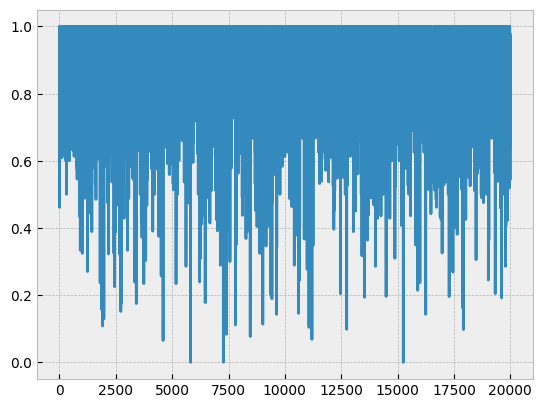

In [6]:
plt.plot((df['Per_Gene_Counts_Unaffected_Unaffected'] / df.sum(1)).to_numpy())

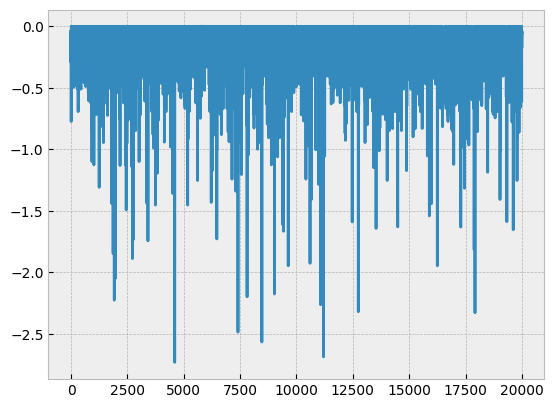

In [7]:
plt.plot(jnp.log((df['Per_Gene_Counts_Unaffected_Unaffected'] / df.sum(1)).to_numpy()))

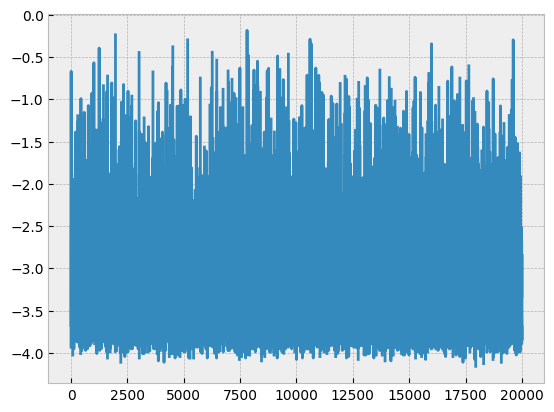

In [8]:
plt.plot(jnp.log((df['Unaffected_Affected'] / df.sum(1)).to_numpy()))

In [9]:
df[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']]

,Per_Gene_Counts_Unaffected_Unaffected,Affected_Unaffected,Unaffected_Affected,Affected_Affected
0,46,2,0,0
1,38,8,1,1
2,43,0,2,0
3,34,0,5,1
4,43,0,2,0
...,...,...,...,...
19995,49,2,2,0
19996,31,0,2,1
19997,32,1,1,0
19998,45,1,1,0


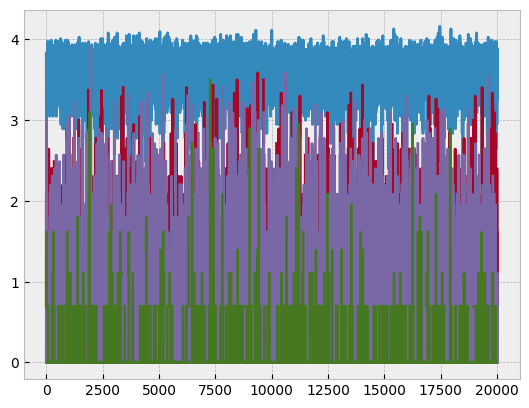

In [10]:
plt.plot(jnp.log((df[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']]).to_numpy()))

In [11]:
q = df.query('(Per_Gene_Counts_Unaffected_Unaffected > 0) | (Affected_Unaffected > 0) | (Unaffected_Affected > 0) | (Affected_Affected > 0)')


/tmp/ipykernel_28726/3967277850.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = (q[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy() + 1)/(np.expand_dims(q['Per_Gene_Counts_Unaffected_Unaffected'].to_numpy(), 1))


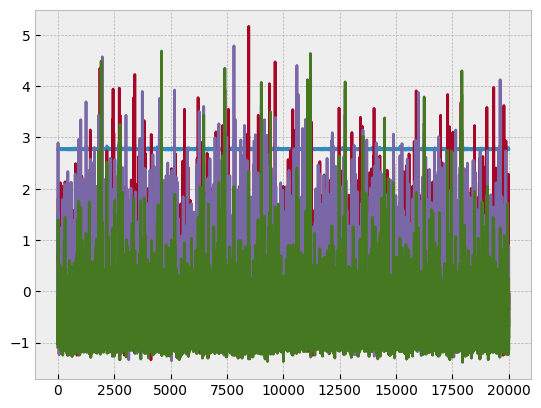

In [12]:
ratio = (q[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy() + 1)/(np.expand_dims(q['Per_Gene_Counts_Unaffected_Unaffected'].to_numpy(), 1))

plt.plot(np.log(ratio / np.median(ratio)))

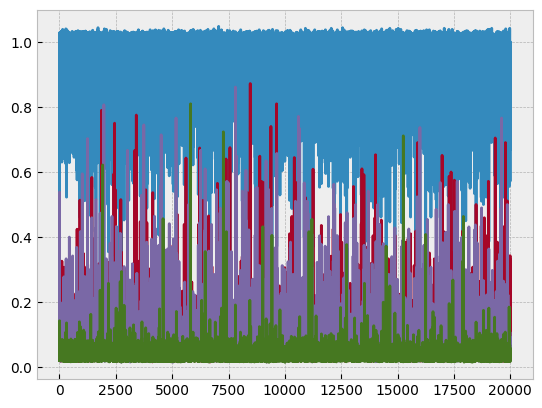

In [13]:
ratio2 = (q[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy() + 1)/(np.expand_dims(q.to_numpy().sum(axis=1), 1))

ratio2
plt.plot(ratio2)

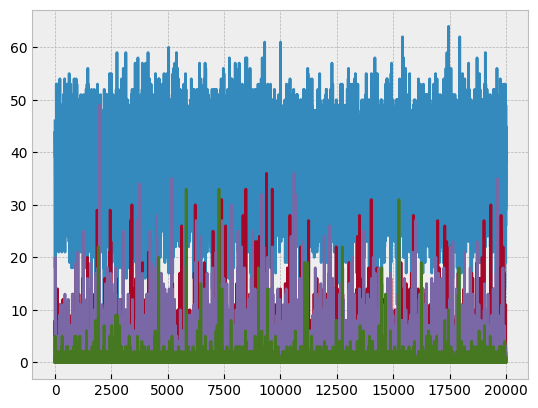

In [14]:
plt.plot(q[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy())

In [15]:
df[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy() + 1

array([[47,  3,  1,  1],
       [39,  9,  2,  2],
       [44,  1,  3,  1],
       ...,
       [33,  2,  2,  1],
       [46,  2,  2,  1],
       [39,  2,  2,  1]])

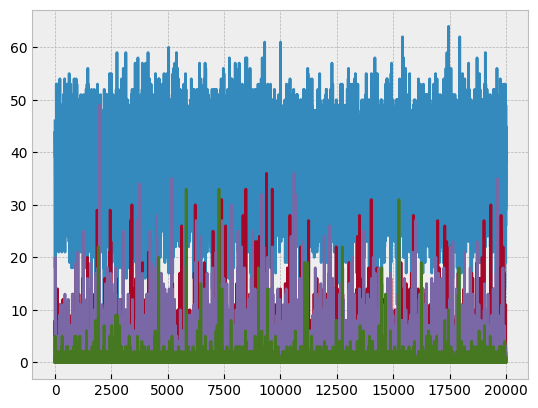

In [16]:
plt.plot(df[['Per_Gene_Counts_Unaffected_Unaffected', 'Affected_Unaffected', 'Unaffected_Affected', 'Affected_Affected']].to_numpy())

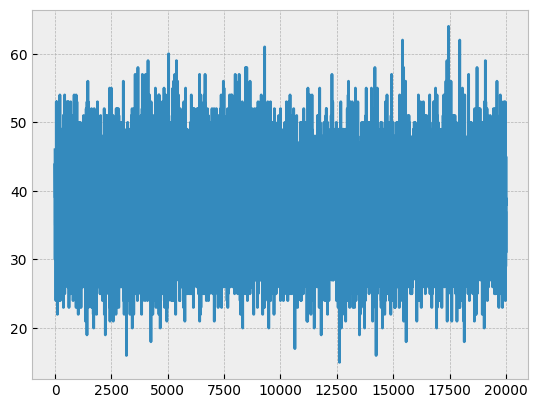

In [17]:
plt.plot(df[df['true_component'] == 0]['Per_Gene_Counts_Unaffected_Unaffected'])

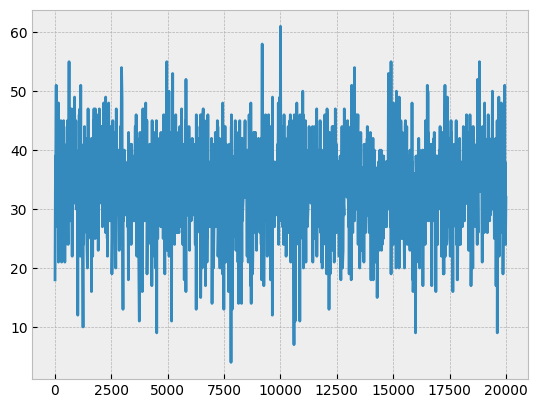

In [18]:
plt.plot(df[df['true_component'] == 1]['Per_Gene_Counts_Unaffected_Unaffected'])

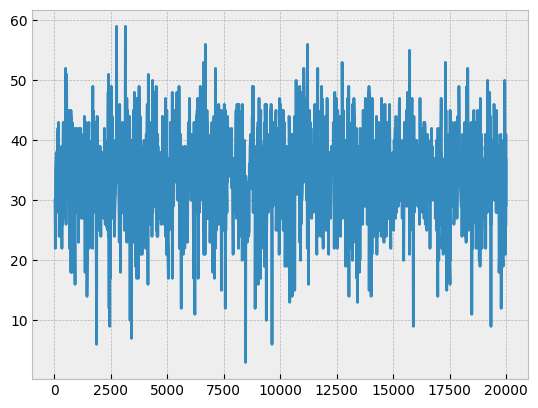

In [19]:
plt.plot(df[df['true_component'] == 2]['Per_Gene_Counts_Unaffected_Unaffected'])

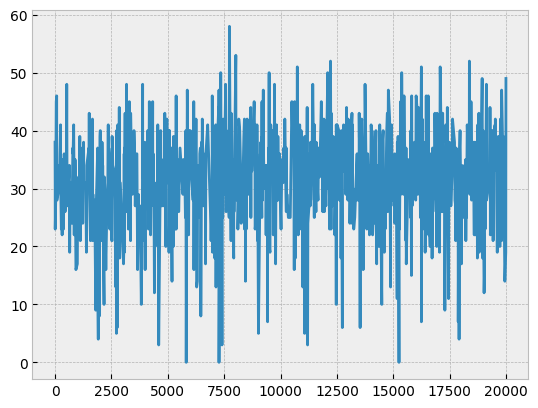

In [20]:
plt.plot(df[df['true_component'] == 3]['Per_Gene_Counts_Unaffected_Unaffected'])

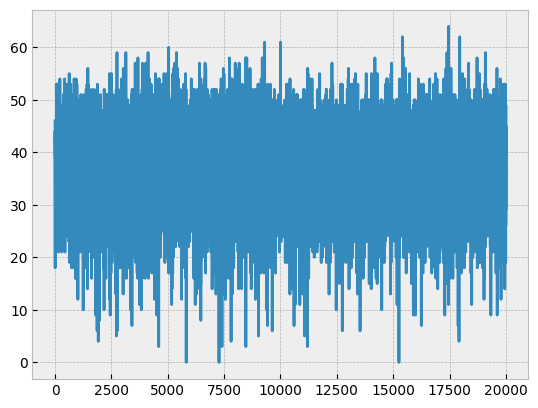

In [21]:
plt.plot(df['Per_Gene_Counts_Unaffected_Unaffected'])

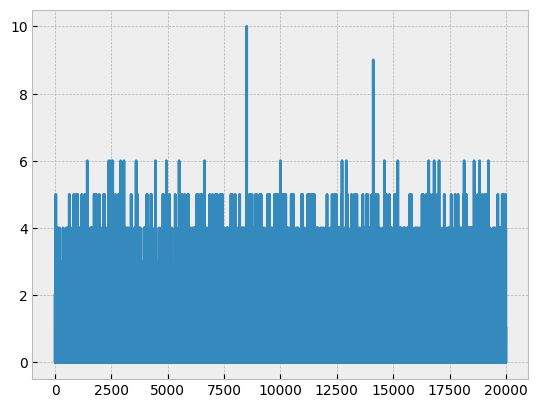

In [22]:
plt.plot(df[df['true_component'] == 0]['Affected_Unaffected'])

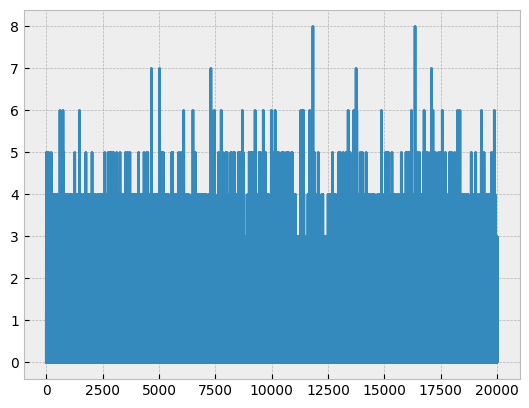

In [23]:
plt.plot(df[df['true_component'] == 0]['Unaffected_Affected'])

In [24]:
df[df['true_component'] == 0]['Unaffected_Affected']

0        0
2        2
3        5
4        2
5        1
        ..
19992    3
19994    0
19996    2
19998    1
19999    1
Name: Unaffected_Affected, Length: 15014, dtype: int64

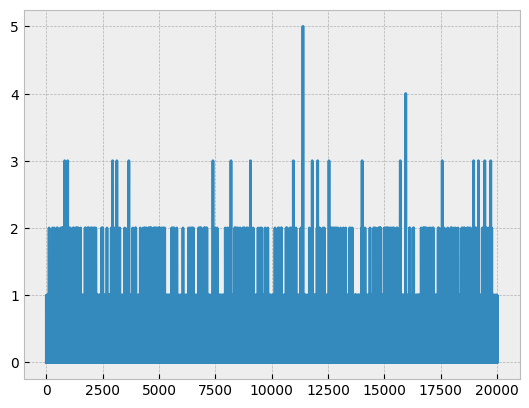

In [25]:
plt.plot(df[df['true_component'] == 0]['Affected_Affected'])

In [26]:
cols = ['Per_Gene_Counts_Unaffected_Unaffected', 'Unaffected_Affected', 'Affected_Unaffected', 'Affected_Affected']
cheats2[cheats2['Gene_Model']==0][cols].mean(0) / cheats2[cheats2['Gene_Model']==0][cols].mean(0).sum()

Per_Gene_Counts_Unaffected_Unaffected    0.931862
Unaffected_Affected                      0.031786
Affected_Unaffected                      0.031443
Affected_Affected                        0.004909
dtype: float64

In [27]:
cheats2[cheats2['Gene_Model']==1][cols].mean(0) / cheats2[cheats2['Gene_Model']==1][cols].mean(0).sum()

Per_Gene_Counts_Unaffected_Unaffected    0.849181
Unaffected_Affected                      0.114551
Affected_Unaffected                      0.026250
Affected_Affected                        0.010018
dtype: float64

In [28]:
cheats2[cheats2['Gene_Model']==2][cols].mean(0) / cheats2[cheats2['Gene_Model']==2][cols].mean(0).sum()

Per_Gene_Counts_Unaffected_Unaffected    0.851241
Unaffected_Affected                      0.026450
Affected_Unaffected                      0.112683
Affected_Affected                        0.009626
dtype: float64

In [29]:
cheats2[cheats2['Gene_Model']==3][cols].mean(0) / cheats2[cheats2['Gene_Model']==3][cols].mean(0).sum()

Per_Gene_Counts_Unaffected_Unaffected    0.787339
Unaffected_Affected                      0.088684
Affected_Unaffected                      0.090775
Affected_Affected                        0.033201
dtype: float64

In [30]:
len(cheats2[cheats2['Gene_Model']==0])/len(cheats2)

0.7507

In [31]:
len(cheats2[cheats2['Gene_Model']==1])/len(cheats2)

0.0994

In [32]:
len(cheats2[cheats2['Gene_Model']==2])/len(cheats2)

0.09905

In [33]:
len(cheats2[cheats2['Gene_Model']==3])/len(cheats2)

0.05085

In [34]:
# with numpyro.handlers.seed(rng_seed=1):
#     trace = numpyro.handlers.trace(model).get_trace(df_data, **{
#         "N": jnp.array(N),
#         'shared_dirichlet_prior': False,
#         "prior_pop_af": 1e-4,
#         "dirichlet_min_ll": -30,
#         "multinomial_min_ll": -5000,
#         "k_hypotheses": 4,
#         "shared_dirichlet_prior": False,
#     })
# print(numpyro.util.format_shapes(trace))

In [38]:
# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "model_args": {
        "data": df_data,
        "k_hypotheses": 4,
    },
    # "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob", "zero_gate")
})
best_chain, stats = select_best_chain(res)
display(stats)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights, best_probs, best_betas, best_dirirchlet_conc = get_parameters(best_chain)

# pds_exp_ns_h2_p5_rho95 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p5_rho95 = np.array([1 - pds_exp_ns_h2_p5_rho95.sum(), *pds_exp_ns_h2_p5_rho95])
var1, var2, cov, rho, debug_architectures = get_rho_bivariate(probs = best_probs, weights = best_weights,
                                         observations = df_data,
                                         true_architectures = genetic_architecture,
                                         concentrations = best_dirirchlet_conc,
                                         # prevalences=pd_with_both_exp_ns_h2_p5_rho95,
                                         n_samples = N.sum())

sample: 100%|█████████████████████████████████████████| 6000/6000 [01:01<00:00, 97.59it/s, 15 steps of size 3.85e-01. acc. prob=0.86]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_pheno[0,0]      6.71      2.26      7.03      3.31     10.00   4835.37      1.00
alpha_pheno[0,1]      6.95      2.20      7.35      3.63     10.00   4438.51      1.00
alpha_pheno[0,2]      6.42      2.30      6.70      3.10     10.00   3777.16      1.00
alpha_pheno[1,0]      6.76      2.26      7.13      3.36     10.00   4033.84      1.00
alpha_pheno[1,1]      2.22      0.99      2.00      1.00      3.56   5802.01      1.00
alpha_pheno[1,2]      7.03      2.14      7.42      3.85     10.00   5279.19      1.00
alpha_pheno[2,0]      6.97      2.21      7.39      3.65      9.99   4098.00      1.00
alpha_pheno[2,1]      5.91      2.24      6.02      2.71      9.91   5175.97      1.00
alpha_pheno[2,2]      6.86      2.28      7.29      3.45     10.00   4916.29      1.00
alpha_pheno[3,0]      4.79      2.20      4.54      1.10      8.06   4571.80      1.00
alpha_pheno[3,1]      4.63      2.11      

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.858096,0.130728,2293613.75,0.0


probs_mean_df.index
hypothesis_order [2 0 1 3]
weights [[0.0298402  0.03171826 0.93555325 0.00288834]
 [0.02916172 0.03466379 0.9318168  0.00435762]
 [0.02920455 0.03388763 0.9329259  0.0039819 ]
 ...
 [0.03248936 0.03109316 0.9325096  0.00390788]
 [0.02665938 0.03311958 0.93701726 0.00320384]
 [0.03239999 0.03154161 0.9322596  0.00379881]]
jnp.median(weights, axis=0)' [0.02968754 0.03259899 0.9342016  0.0033794 ]


TypeError: median requires ndarray or scalar arguments, got <class 'NoneType'> at position 0.

In [ ]:
best_weights

In [ ]:
best_chain.print_summary()
weights, probs, _, _ = get_parameters(best_chain)
print("weights mean", jnp.mean(weights, axis=0))
print("probs mean", jnp.mean(probs, axis=0))

In [ ]:
best_chain, stats = select_best_chain(res)
display(stats)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights, best_probs, best_betas, best_dirirchlet_conc = get_parameters(best_chain)

# pds_exp_ns_h2_p5_rho95 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p5_rho95 = np.array([1 - pds_exp_ns_h2_p5_rho95.sum(), *pds_exp_ns_h2_p5_rho95])
var1, var2, cov, rho, debug_architectures = get_rho_bivariate(probs = best_probs, weights = best_weights,
                                         observations = df_data,
                                         true_architectures = genetic_architecture,
                                         concentrations = best_dirirchlet_conc,
                                         # prevalences=pd_with_both_exp_ns_h2_p5_rho95,
                                         n_samples = N.sum)

In [ ]:
print('best_betas', mix_weights(best_betas))

In [ ]:
Dirichlet(jnp.array([1,2,3,4])).sample(jax.random.PRNGKey(1)).mean

In [ ]:
# ll shape (4, 20000)
# self.gate shape (4, 1)
value_test = np.random.rand(20_000,4).T
print(value_test)
ll_test = np.random.rand(4, 20_000)
gate_test = np.random.rand(4,1)
ll_test + gate_test

np.log1p(-gate_test) +  np.where(value_test < 1, jnp.log(gate_test + jnp.exp(ll_test)), ll_test)

In [ ]:
res_shared = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_data,
    "k_hypotheses": 4,
    "model": model,
    'num_data':df_data.shape[0],
    'shared_dirichlet_prior': True
})
best_chain_shared, stats_shared = select_best_chain(res_shared)
display(stats_shared)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_shared, best_probs_shared, best_betas_shared, best_dirirchlet_conc_shared = get_parameters(best_chain_shared)

# pds_exp_ns_h2_p5_rho95 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p5_rho95 = np.array([1 - pds_exp_ns_h2_p5_rho95.sum(), *pds_exp_ns_h2_p5_rho95])
var1_shared, var2_shared, cov_shared, rho_shared, debug_architectures_shared = get_rho_bivariate(probs = best_probs_shared, weights = best_weights_shared,
                                         observations = df_data,
                                         true_architectures = genetic_architecture,
                                         concentrations = best_dirirchlet_conc_shared,
                                         # prevalences=pd_with_both_exp_ns_h2_p5_rho95,
                                         n_samples = n_samples)

In [ ]:
stats

In [ ]:
np.all(df_data == mean_prior_pred)

In [ ]:
# Prior predictions
samples_1 = best_chain_shared.get_samples()

rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, num_data=df_data.shape[0], data=df_data)
print('prior_predictions', prior_predictions['alpha'])
mean_prior_pred = jnp.mean(prior_predictions['obs'], axis=0)
hpdi_prior_pred = hpdi(prior_predictions['obs'], 0.9)

# ax = plot_regression(df_data, mean_prior_pred, hpdi_prior_pred)
# ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");
mean_prior_pred

In [ ]:
samples_1

In [ ]:
df

In [ ]:
# Posterior predictions
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, num_data=df_data.shape[0], data=df_data)
mean_predictions = np.mean(predictions["obs"], axis=0)
# df['Predicted_Unaffected_Unaffected'] = mean_predictions[:,0]
# df['Predicted_Unaffected_Affected'] = mean_predictions[:,1]
# df['Predicted_Affected_Unaffected'] = mean_predictions[:,2]
# df['Predicted_Affected_Affected'] = mean_predictions[:,3]
# df

In [ ]:
predictions

In [ ]:
predictions_rep1['pz'][:,hyp

In [ ]:
predictive['probs']

In [ ]:
hypothesis_order, d = get_assumed_order_bivariate(post['probs'], data=df_data)

In [ ]:
# Posterior on unseen data
run_basename_rep1 = 'sim/test_new_steez_prevalence_.02_h2_.5_rho_.8_pi.1_piboth_05_rep1'
cheats_rep1 = pd.read_csv(f'{run_basename_rep1}.cheat.tsv', sep='\t')

df_rep1 = pd.read_csv(run_basename_rep1)
df_rep1 = df_rep1.join(cheats_rep1)
display(df_rep1)
predictions_rep1 = predictive(rng_key_, num_data=df_data.shape[0], data=jnp.array(df_rep1))
mean_predictions_rep1 = np.mean(predictions_rep1["obs"], axis=0)
mean_z_rep1 = np.mean(predictions_rep1["z"], axis=0)

df_rep1['Predicted_Unaffected_Unaffected'] = mean_predictions_rep1[:,0]
df_rep1['Predicted_Unaffected_Affected'] = mean_predictions_rep1[:,1]
df_rep1['Predicted_Affected_Unaffected'] = mean_predictions_rep1[:,2]
df_rep1['Predicted_Affected_Affected'] = mean_predictions_rep1[:,3]
df_rep1['Predicted_class'] = mean_z_rep1
df_rep1.to_excel(f'{run_basename_rep1}.results.xlsx')
df_rep1

In [ ]:
df_rep1.join(cheats_rep1)

In [ ]:
import scipy
scipy.stats.mode(predictions_rep2['pz'],0)[0][0][0:1000]

In [ ]:
predictions_rep2['pz'][100:300]

In [ ]:
# Posterior on unseen data
run_basename_rep2 = 'sim/test_new_steez_prevalence_.02_h2_.5_rho_.8_pi.1_piboth_05_rep2'
df_rep2 = pd.read_csv(run_basename_rep2)
display(df_rep2)
predictions_rep2 = predictive(rng_key_, num_data=df_rep2.shape[0], data=jnp.array(df_rep2))
mean_predictions_rep2 = np.mean(predictions_rep2["obs"], axis=0)
df_rep2['Predicted_Unaffected_Unaffected'] = mean_predictions_rep2[:,0]
df_rep2['Predicted_Unaffected_Affected'] = mean_predictions_rep2[:,1]
df_rep2['Predicted_Affected_Unaffected'] = mean_predictions_rep2[:,2]
df_rep2['Predicted_Affected_Affected'] = mean_predictions_rep2[:,3]
df_rep2

In [ ]:
prior_predictions['gamma_shape'].mean(0)

In [ ]:
best_chain.summary(prob=.95)

In [ ]:
best_chain?

In [ ]:
posterior_samples = best_chain.get_samples()
predictive = Predictive(model, posterior_samples, infer_discrete=True)
discrete_samples = predictive(random.PRNGKey(1), num_data=df_data.shape[0], alpha=prior_predictions['alpha'].mean(0), gamma_rate=prior_predictions['gamma_rate'].mean(0), k_hypotheses=4, gamma_shape=prior_predictions['gamma_shape'].mean(0), data=None)
discrete_samples

In [ ]:
discrete_samples['z'][0][0:500]

In [ ]:
hpdi_prior_pred

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, data=df_data)["obs"]
predictions
# df = dset.filter(["Location"])
# df["Mean Predictions"] = jnp.mean(predictions, axis=0)
# df.head()

In [ ]:
#https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html
post = best_chain.get_samples()
dat = dict(data = jnp.array(df_data), k_hypotheses = 4, alpha = .05/4, shared_dirichlet_prior = False)
pred = Predictive(best_chain.sampler.model, post)
pred = pred(random.PRNGKey(1), **dat)
# post['z'] = pred['z']
# post

mix_weights(post['beta']).mean(0)

In [ ]:
probs_t = post['probs'][0]
probs_t = post['probs'][0]
# best_weights, best_probs, best_betas, best_dirirchlet_conc 
probs_t

In [ ]:
# I think these are prevalences, look how closely they match dave's numbers!!
#   "prevalence_expected": [
  #   0.02,
  #   0.02
  # ],
  # "prevalence _actual": [
  #   0.03634,
  #   0.03661
  # ],
best_weights[0]

In [ ]:
probs_t

In [ ]:
pred['obs'][0][0]

In [ ]:
hypothesis_order, d = get_assumed_order_bivariate(post['probs'], data=df_data)

ordered_weights = post['pz'][:,hypothesis_order]
ordered_probs = post['probs'][:,hypothesis_order]
ordered_concentrations = post['dirichlet_concentration'][:,hypothesis_order]
jnp.median(ordered_concentrations,0)

In [ ]:
jnp.mean(ordered_concentrations,0)

In [ ]:
ordered_concentrations.std(0)

In [ ]:
Dirichlet(ordered_concentrations).sample(random.PRNGKey(1), sample_shape=(100,)).mean(1).mean(0)

In [ ]:
jnp.median(Dirichlet(ordered_concentrations).sample(random.PRNGKey(1), sample_shape=(100,)).mean(1), 0)

In [ ]:
jnp.median(ordered_probs,0)

In [ ]:
jnp.median(Dirichlet(ordered_concentrations).sample(random.PRNGKey(1), sample_shape=(100,)).mean(1), 0)

In [ ]:
Dirichlet(ordered_concentrations.mean(0)).sample(random.PRNGKey(1), sample_shape=(100,)).mean(0)/Dirichlet(ordered_concentrations.mean(0)).sample(random.PRNGKey(1), sample_shape=(100,)).mean(0)[0]

In [ ]:
ordered_probs.mean(0)/ordered_probs.mean(0)[0]

In [ ]:
# hypothesis_order, d = get_assumed_order_bivariate(post['probs'], data=df_data)

# ordered_weights = post['pz'][0][hypothesis_order]
# ordered_probs = probs_t[hypothesis_order]
# ordered_concentrations = post['dirichlet_concentration'][0][hypothesis_order]
# ordered_concentrations

In [ ]:
post['dirichlet_concentration'][:,hypothesis_order]

In [ ]:
d

In [ ]:
ordered_probs

In [ ]:
ordered_weights

In [ ]:
ordered_probs

In [ ]:
t = Multinomial(probs=ordered_probs).log_prob(pred['obs'][0][9])
t.sum()

In [ ]:
from numpyro.distributions import *
t = Multinomial(probs=ordered_probs).log_prob(pred['obs'][0][9])
t = t * ordered_weights

t

In [ ]:
df_data.shape

In [ ]:
jnp.expand_dims(ordered_probs,axis=0).shape

In [ ]:
jnp.all(pred['obs'][0] == pred['obs'][1])

In [ ]:
@jax.jit
def get_posterior_z(ordered_probs, ordered_weights, observations):
    t = Multinomial(probs=jnp.median(ordered_probs,0))
    ow = jnp.log(jnp.median(ordered_weights, 0))
    
    al = []
    for obs in observations:
        # print(obs)
        t2 = t.log_prob(obs) + ow
        A = jnp.max(t2)
        ak_a = t2-A
        logsum = A + jnp.log(jnp.exp(ak_a).sum())
        # print("logsum, t2", logsum, t2)
        # print(jnp.exp(t2 - logsum))
    
        al.append(jnp.exp(t2 - logsum))
    
    return jnp.array(al)

def get_posterior_z_slow(ordered_probs, ordered_weights, observations):
    t = Multinomial(probs=jnp.median(ordered_probs,0))
    ow = jnp.log(jnp.median(ordered_weights, 0))
    print('np.array(observations)',jnp.array(observations))
    al = []
    for obs in jnp.array(observations):
        # print(obs)
        t2 = t.log_prob(obs) + ow
        A = np.max(t2)
        ak_a = t2-A
        logsum = A + jnp.log(jnp.exp(ak_a).sum())
        # print("logsum, t2", logsum, t2)
        # print(jnp.exp(t2 - logsum))
    
        al.append(jnp.exp(t2 - logsum))
    
    return jnp.array(al)

def get_posterior_z_fastest(ordered_probs, ordered_weights, observations):
    t = Multinomial(probs=ordered_probs)
    
    al = []
    for obs in observations:
        t2 = t.log_prob(obs) + jnp.log(ordered_weights)
        t2 = jnp.median(t2,0)
        A = jnp.max(t2)
        ak_a = t2-A
        logsum = A + jnp.log(jnp.exp(ak_a).sum())
    
        al.append(jnp.exp(t2 - logsum))
    
    return jnp.array(al)

# test = make_posterior_z(ordered_probs, ordered_weights)
# al = []
# for obs in df_data:
#     al.append(test(obs))
# import time
# start = time.time()
# all_pz_post = get_posterior_z(ordered_probs, ordered_weights, df_data[0:100])
# display(f"Took: {time.time()-start} for jitted")
# start = time.time()
# all_pz_post2 = get_posterior_z_slow(ordered_probs, ordered_weights, df_data)
# display(f"Took: {time.time()-start} for non-jitted")

In [ ]:
null_indices = np.where(genetic_architecture == 0)[0]
not_null_indices = np.where(genetic_architecture != 0)[0]

not_null = all_pz_post2[not_null_indices]
print('not_null length', len(not_null))
print('called not null', len(np.where(np.argmax(not_null, 1) != 0)[0]))
called_null_when_not = np.where(np.argmax(not_null, 1) == 0)[0]
print('called null', len(called_null_when_not))
display("called null when not", not_null[called_null_when_not])
display("df_data[called_null_when_not]", df_data[called_null_when_not])

results = []
for d in np.array(df_data):
    # print('weird obs', d)
    weird = d
    t = Multinomial(probs=np.array(ordered_probs))
    # print('t.log_prob(weird)', t.log_prob(weird).shape, ordered_weights.shape)
    weird_lp = t.log_prob(weird) + np.log(np.array(ordered_weights))
    # print('weird_lp', weird_lp.shape)
    weird_A = np.max(weird_lp, 1)
    # print('weird_A', weird_A)
    weird_ak_a = weird_lp-np.expand_dims(weird_A,1)
    # print('weird_ak_a', weird_ak_a)
    # print('A', weird_A)
    weird_logsum = weird_A + np.log(np.exp(weird_ak_a).sum(1))
    # print('weird_logsum', weird_logsum)
    res = np.exp(weird_lp - np.expand_dims(weird_logsum,1))
    # display('res', res)
    # print('res.median', jnp.median(res,0))
    results.append(res)

results = np.array(results)
results
# t2 = t.log_prob(obs) + ow
#         A = jnp.max(t2)
#         ak_a = t2-A
#         logsum = A + jnp.log(jnp.exp(ak_a).sum())
#         # print("logsum, t2", logsum, t2)
#         # print(jnp.exp(t2 - logsum))
    
#         al.append(jnp.exp(t2 - logsum))
    

In [ ]:
results_median = np.median(results,1)
results_median

In [ ]:
not_null.shape

In [ ]:
wtf_indices = np.where((genetic_architecture != 0) & (np.argmax(all_pz_post2, 1) == 0))
display(wtf_indices)
display(df_data[wtf_indices])
wtf1 = all_pz_post2[np.where((genetic_architecture != 0) & (np.argmax(all_pz_post2, 1) == 0))[0],:]
wtf1

In [ ]:
wtf2 = results_median[np.where((genetic_architecture != 0) & (np.argmax(results_median, 1) == 0))[0],:]
wtf2

In [ ]:
right, wrong = np.where(np.argmax(results[null_indices],2)==0)
print('right', len(right), 'wrong', len(wrong))

In [ ]:
results[null_indices].reshape((4000, 15014, 4)).shape

In [ ]:
np.argmax(results[null_indices],2)

In [ ]:
(np.argmax(results[null_indices],2) != 0).astype('int').sum(1)

In [ ]:
np((np.argmax(results[null_indices],2) == 0)).sum(1)

In [ ]:
np.argmax(results[null_indices],2)

In [ ]:
results[null_indices].shape[1]

In [ ]:
np.where(np.argmax(results[null_indices],2) == 0)[0]

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC379178/
n = results[null_indices].shape[1] +1
r = (np.argmax(results[null_indices],2) != 0).astype('int').sum(1) + 1
r/n

In [ ]:
(np.argmax(results[null_indices],2) != 0).astype('int').shape

In [ ]:
max

In [ ]:
np.linspace(0, r.shape[0], 1)

In [ ]:
np.sort(r/n)
z = Normal(0,1).icdf(percentiles)
z

In [ ]:
!pip install statsmodels

In [ ]:
sm.NegativeBinomial

In [ ]:
import statsmodels.api as sm
sm.qqplot(r)

In [ ]:
np.log10(r/n)

In [ ]:
np.log10(r/n)

In [ ]:
percentiles = (np.array(range(r.shape[0])) - .5)/r.shape[0]
plt.scatter(np.log10(r/n), z)

In [ ]:
np.median(results[null_indices],1)[:,0]

In [ ]:
percentiles = (np.array(range(r.shape[0])) - .5)/r.shape[0]
plt.scatter(np.median(results[null_indices],1)[:,0], z)

In [ ]:
import scipy
scipy.special.qqplot

In [ ]:
null = results_median[np.where((genetic_architecture != 0) & (np.argmax(results_median, 1) == 0))[0],:]
wtf2

In [ ]:
plt.scatter(wtf2[:,0],wtf2[:,1:].sum(1))

In [ ]:
!pip install pylab

In [ ]:
import scipy.stats as stats
# import pylab 
stats.probplot(wtf2[:,0], dist=stats.binom(200_000, .93), plot=pylab)
# pylab.show()

In [ ]:
wtf2[:,0]

In [ ]:
wtf2.shape

In [ ]:
wtf1.shape

In [ ]:
t = Multinomial(probs=ordered_probs)
t.log_prob(pred['obs'][0].reshape((4,20_000))).shape

# @jax.jit
# def logsumexp(ordered_probs, ordered_weights, observation):
#     t = Multinomial(probs=ordered_probs)
    
#     al = []
#     for obs in observations:
#         t2 = t.log_prob(obs) + jnp.log(ordered_weights)
#         t2 = jnp.median(t2,0)
#         A = jnp.max(t2)
#         ak_a = t2-A
#         logsum = A + jnp.log(jnp.exp(ak_a).sum())
    
#         al.append(jnp.exp(t2 - logsum))
    
#     return jnp.array(al)

In [ ]:
pred['obs']

In [ ]:
post['dirichlet_concentration'][:,hypothesis_order].shape

In [ ]:
post['dirichlet_concentration'][:,hypothesis_order].shape

In [ ]:
from numpyro.distributions import *
jnp.exp(DirichletMultinomial(post['dirichlet_concentration'][:,hypothesis_order]).log_prob(pred['obs'][0][1]))

In [ ]:
ordered_concentrations[0]

In [ ]:
post['dirichlet_concentration'][0]

In [ ]:
ordered_probs[0]

In [ ]:
post['probs'][0]

In [ ]:
from numpyro.distributions import *
allem = jnp.exp(DirichletMultinomial(ordered_concentrations[0]).log_prob(pred['obs'][0][1])) #* ordered_weights[0]

allem / allem.sum()

In [ ]:
from numpyro.distributions import *
allem = jnp.exp(Multinomial(probs=ordered_probs[0]).log_prob(pred['obs'][0][1])) #* ordered_weights[0]

allem / allem.sum()

In [ ]:
np.where(genetic_architecture == 3)

In [ ]:
genetic_architecture[19988]

In [ ]:
pred['obs'][0][19988]

In [ ]:
from numpyro.distributions import *
jnp.exp(DirichletMultinomial(ordered_probs).log_prob(pred['obs'][0][1]))

In [ ]:
from numpyro.distributions import *
jnp.exp(DirichletMultinomial(probs_t).log_prob(pred['obs'][0][1])) * post['pz'][0]

In [ ]:
#https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html
post = best_chain.get_samples()
dat = dict(data = jnp.array(df_data), k_hypotheses = 4, alpha = .05/4, shared_dirichlet_prior = False)
pred = Predictive(best_chain.sampler.model, post)
pred = pred(random.PRNGKey(1), **dat)
post['z'] = pred['z']
post

In [ ]:
print_summary(post, .89, False)

In [ ]:
pred['pz']

In [ ]:
jnp.where(pred['z'][0] == 1)

In [ ]:
pred['obs'][545]

In [ ]:
pred['pz'].shape

In [ ]:
pred(random.PRNGKey(1), **dat)['obs'][0][0]

In [ ]:
post['pz'] = pred(random.PRNGKey(1), **dat)['pz']
post['pz']

In [ ]:
post['pz'].std(0)

In [ ]:
import json
with open(f'{run_basename}.json') as f:
    r3 = json.load(f)
r3

real_prevalences = np.array([1- sum(r3['observed_prevalences']), *r3['observed_prevalences']])
n_samples_b = r3['total_N'] * real_prevalences
var1_b, var2_b, cov_b, rho_b, debug_architectures_b = get_rho_bivariate(probs = best_probs, weights = best_weights,
                                         observations = df_data,
                                         true_architectures = genetic_architecture,
                                         concentrations = best_dirirchlet_conc,
                                         # prevalences=real_prevalences,
                                         n_samples = 200_000)
# P_D1 0.039945 P_D2 0.04032499999999999

In [ ]:
def get_rho_bivariate2(probs, weights, concentrations, observations: np.array, n_samples: Union[int, np.array], prevalences = None, hypothesis_order = None, true_architectures: np.ndarray = None):
    """
    Requires index 3 to be cases for both and index 1 & 2 to be affected by 1, affected by 2, or vice versa
    """
    if hypothesis_order is None:
        hypothesis_order, _ = get_assumed_order_bivariate(probs, data=observations)

    ordered_weights = weights.mean(0)[hypothesis_order]
    ordered_probs = probs.mean(0)[hypothesis_order]
    ordered_concentrations = concentrations.mean(0)[hypothesis_order]
    print('ordered_weights', ordered_weights)
    print('ordered_probs', ordered_probs)

    dm_model = DirichletMultinomial(concentration=ordered_concentrations)
    # TODO: should we just take this directly from n_samples (make that a vec of ctrl, case1, case2, caseBoth)
    # TODO: name this in-sample prevalences to distinguish from population prevalence?
    # TODO: should we use population prevalence of sample prevalence below?
    if prevalences is None:
        # Alternative estimate, using weighted posterior: (ordered_weights @ ordered_probs)
        prevalences = (observations/observations.sum(1).reshape(observations.shape[0], 1)).mean(0)
        # print("prevalence estimate", prevalences)
        prevalences2 = (ordered_weights @ ordered_probs)
        print('posterior prevalence estimate', prevalences)
        print('posterior prevalence estimate using our stuff', prevalences2)
    else:
        print("Prevalence passed: ", prevalences)
        print("would have used as posterior prevalence estimate: ", (ordered_weights @ ordered_probs))

    if isinstance(n_samples, int):
        print("Estimating sample breakdown using prevalences")
        # sample_proportions = (observations/observations.sum(1).reshape(observations.shape[0], 1)).mean(0)
        n_samples = prevalences * n_samples
    alleles = n_samples*2
    alleles_ctrls, alleles_one_only, alleles_two_only, alleles_both = alleles
    print("alleles", alleles)

    alleles_ctrl1 = alleles_ctrls + alleles_two_only
    alleles_ctrl2 = alleles_ctrls + alleles_one_only
    alleles_case1 = alleles_one_only + alleles_both
    alleles_case2 = alleles_two_only + alleles_both

    P_D1 = prevalences[1]#(n_samples[3] + n_samples[1]) / (n_samples.sum())
    P_D2 = prevalences[2]#(n_samples[3] + n_samples[2]) / (n_samples.sum())

    thresh1 = Inv_Cumulative_Normal(1 - P_D1)
    thresh2 = Inv_Cumulative_Normal(1 - P_D2)

    print('P_D1', P_D1, 'P_D2', P_D2)

    n_genes_used = 0

    if not (type(true_architectures) is np.ndarray and true_architectures.size == len(observations)):
        true_architectures = [None] * len(observations)

    how_many_wrong = 0
    how_many_right = 0
    how_many_mixed_up_one_two = 0
    how_many_mixed_up_both_and_one_or_two = 0
    how_many_called_risk_when_nonrisk = 0
    how_many_called_nonrisk_when_risk = 0
        
    tot_post_neither = 0
    tot_post_one = 0
    tot_post_two = 0
    tot_post_both = 0
    tot_post_affected = 0
    
    cov_sum = 0
    sigma1_mean_est = 0
    sigma1_squared_est = 0 
    sigma2_mean_est = 0
    sigma2_squared_est = 0 
    
    n_is_both = 0
    n_is_two = 0
    n_is_one = 0
    n_is_neither = 0

    inf_rows = 0
    print_out_architecture = []
    nulls = 0
    predicted_null_pvalues = []
    dist = DirichletMultinomial(ordered_probs)
    max_likelihood = jnp.exp(dist.log_prob(obs))
    for i, obs in enumerate(observations):
        x_ctrl, x_one, x_two, x_both = obs
        
        if true_architectures[i] != 0:
            continue
        
        
        nulls += 1
        
        L_D_given_z = (ordered_probs ** obs).prod(1)
        P_z_i2 = np.multiply(ordered_weights, L_D_given_z)        
        P_z_i2 = P_z_i2/P_z_i2.sum()
        
        
        # print('P_z_i2', P_z_i2)
        predicted_null_pvalues.append(P_z_i2[0])
        continue

        the_architecture = np.argmax(P_z_i2)
        if the_architecture == 1:
            n_is_two += 1
        elif the_architecture == 2:
            n_is_one += 1
        elif the_architecture == 0:
            n_is_neither += 1
        elif the_architecture == 3:
            n_is_both += 1

        if the_architecture == true_architectures[i]:
            how_many_right += 1
        else:
            how_many_wrong += 1

            if (the_architecture == 1 or the_architecture == 2):
                if true_architectures[i] == 1 or true_architectures[i] == 2:
                    how_many_mixed_up_one_two += 1
                elif true_architectures[i] == 3:
                    how_many_mixed_up_both_and_one_or_two += 1
                else:
                    how_many_called_risk_when_nonrisk += 1
            elif the_architecture == 3:
                if true_architectures[i] == 1 or true_architectures[i] == 2:
                    how_many_mixed_up_both_and_one_or_two += 1
                else:
                    how_many_called_risk_when_nonrisk += 1

            elif the_architecture == 0:
                how_many_called_nonrisk_when_risk += 1

        print_out_architecture.append([i, the_architecture, true_architectures[i], obs, P_z_i2])

        post_neither, post_one, post_two, post_both = P_z_i2

        # if the_architecture == 0:
        #     continue

        if post_both < .005:
            continue

        n_genes_used += 1

        P_V_Ctrl1 = (x_ctrl + x_two) / alleles_ctrl1
        P_V_Ctrl2 = (x_ctrl + x_one) / alleles_ctrl2
        P_V_Case1 = (x_one + x_both) / alleles_case1
        P_V_Case2 = (x_two + x_both) / alleles_case2

        # P_V_Ctrl1 = 1 - x_on1 + x_both
        P_V_1  = P_V_Ctrl1 * (1 - P_D1) + P_V_Case1 * P_D1
        P_D1_V = P_V_Case1 * P_D1 / P_V_1
        sigma1 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_V)

        P_V_2  = P_V_Ctrl2 * (1 - P_D2) + P_V_Case2 * P_D2
        P_D2_V = P_V_Case2 * P_D2 / P_V_2      
        sigma2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_V)
        if np.isinf(sigma2) or np.isinf(sigma1):
            inf_rows += 1
            continue
        # print("arch vs PD", the_architecture, P_D1_V, P_D2_V)

        # print("P_D2_V", P_D2_V, "P_V_2", P_V_2, "P_D1_V", P_D1_V, "P_V_1", P_V_1)

        tot_post_neither += post_neither
        tot_post_one += post_one + post_both
        tot_post_two += post_two + post_both
        tot_post_both += post_both
        tot_post_affected += post_one + post_two + post_both

        # print("posts", post_one, post_two, post_both)
    
        sigma1_mean_est += (post_one + post_both) * sigma1
        sigma1_squared_est += (post_one + post_both) * sigma1 * sigma1
        
        sigma2_mean_est += (post_two + post_both) * sigma2
        sigma2_squared_est += (post_two + post_both) * sigma2 * sigma2
        
        cov_sum += post_both * sigma1 * sigma2
     
        i += 1
    return predicted_null_pvalues, nulls

    sigma1_mean_est_f = sigma1_mean_est / tot_post_one
    sigma1_squared_est_f = sigma1_squared_est / tot_post_one
    var1_est = (sigma1_squared_est_f - sigma1_mean_est_f**2) 

    sigma2_mean_est_f = sigma2_mean_est / tot_post_two
    sigma2_squared_est_f = sigma2_squared_est / tot_post_two
    var2_est = (sigma2_squared_est_f - sigma2_mean_est_f**2) 

    cov_sum_f = cov_sum / tot_post_both
    cov = cov_sum_f - sigma1_mean_est_f*sigma2_mean_est_f

    rho = cov / (var1_est * var2_est)**.5

    print('n_genes_used', n_genes_used)
    print('tot_post_one', tot_post_one)
    print('tot_post_two', tot_post_two)
    print('tot_post_both', tot_post_both)
    print('inf_rows', inf_rows)
    print('cov_sum_f', cov_sum_f)
    print('sigma1_mean', sigma1_mean_est_f)
    print('sigma1_^2_mean', sigma1_squared_est_f)
    print('sigma2_mean', sigma2_mean_est_f)
    print('sigma2_^2_mean', sigma2_squared_est_f)
    print('cov', cov)
    print('rho', rho)

    print("how_many_wrong", how_many_wrong)
    print("how_many_right", how_many_right)
    print("how_many_mixed_up_one_two", how_many_mixed_up_one_two)
    print("how_many_mixed_up_both_and_one_or_two", how_many_mixed_up_both_and_one_or_two)
    print("how_many_called_risk_when_nonrisk", how_many_called_risk_when_nonrisk)
    print("how_many_called_nonrisk_when_risk", how_many_called_nonrisk_when_risk)
    print('total nulls', nulls)

    return var1_est, var2_est, cov, rho, pd.DataFrame(print_out_architecture, columns=["i", "estimated genetic architecture", "real", "obs", 'P_z_i2'])

In [ ]:
predicted_null_pvalues, nulls = get_rho_bivariate2(probs = best_probs, weights = best_weights,
                                         observations = df_data,
                                         true_architectures = genetic_architecture,
                                         concentrations = best_dirirchlet_conc,
                                         # prevalences=real_prevalences,
                                         n_samples = 200_000)

In [ ]:
nulls

In [ ]:
len(predicted_null_pvalues)

In [ ]:
plot(predicted_null_pvalues)

In [ ]:
from scipy.stats import probplot

In [ ]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
probplot(predicted_null_pvalues, plot=ax1)

In [ ]:
plt.plot(predicted_null_pvalues)